In [1]:
from reprolab.experiment import start_experiment, end_experiment
start_experiment()


2025-07-16 10:49:40 - INFO - Starting experiment process
2025-07-16 10:49:40 - INFO - Step 1: Saving all notebooks
2025-07-16 10:49:40 - INFO - Attempting to save all Jupyter notebooks...
2025-07-16 10:49:41 - INFO - ipylab save command executed successfully
2025-07-16 10:49:41 - INFO - nbformat processing completed for 4 notebooks
2025-07-16 10:49:42 - INFO - Jupyter save commands executed successfully
2025-07-16 10:49:42 - INFO - All save methods completed
2025-07-16 10:49:42 - INFO - Step 2: Determining next tag name
2025-07-16 10:49:42 - INFO - Determining next tag name
2025-07-16 10:49:42 - INFO - Fetching all tags from remote repositories
2025-07-16 10:49:43 - INFO - Found 14 tags: ['v1.0.0', 'v1.1.0', 'v1.10.0', 'v1.11.0', 'v1.12.0', 'v1.13.0', 'v1.2.0', 'v1.3.0', 'v1.4.0', 'v1.5.0', 'v1.6.0', 'v1.7.0', 'v1.8.0', 'v1.9.0']
2025-07-16 10:49:43 - INFO - Latest tag: v1.13.0, next tag: v1.14.0
2025-07-16 10:49:43 - INFO - Step 3: Committing with message: 'Project state before runnin

'v1.14.0'

In [2]:
# Cell 1: Loading CSV data from local file
!pip install pandas
import pandas as pd
from reprolab.experiment import persistio

@persistio()
def load_csv_data():
    return pd.read_csv('books.csv')

books_csv = load_csv_data()
print("Initial CSV data:")
print(books_csv.head())



[persistio] Function: load_csv_data
[persistio] Hash: fd6c2a5e2f8bf4da3913aa47a8a83f5c
✅ Metadata written to test_notebook_before_reprolab.ipynb_persistio_archive.yaml
[persistio] Trigger logged for function: load_csv_data
[persistio] Attempting to load from local cache...
[persistio] Successfully loaded from local cache!
Initial CSV data:
                   title               author  publication_year
0       The Great Gatsby  F. Scott Fitzgerald              1925
1                   1984        George Orwell              1949
2  To Kill a Mockingbird           Harper Lee              1960


In [3]:
# Cell 2: Setting API key

@persistio()
def get_openlibrary_api_key():
    with open("OPENLIBRARY_API_KEY.txt", "r") as file:
        return file.read().strip()


In [4]:
# Cell 3: Getting API data
!pip install requests
import requests
import pandas as pd
import os

@persistio()
def get_book_details(title):
    OPENLIBRARY_API_KEY = get_openlibrary_api_key()
    
    url = f"https://openlibrary.org/search.json?title={title}&apikey={OPENLIBRARY_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data['docs']:
            book = data['docs'][0]
            return {
                'isbn': book.get('isbn', ['N/A'])[0],
                'page_count': book.get('number_of_pages_median', 0),
                'first_publish': book.get('first_publish_year', None)
            }
    return {'isbn': 'N/A', 'page_count': 0, 'first_publish': None}

api_data = books_csv['title'].apply(get_book_details)
api_df = pd.DataFrame(api_data.tolist())
api_df



[persistio] Function: get_book_details
[persistio] Hash: 77ea162d6bac6e4c3c609ef2b3f1e053
✅ Metadata written to test_notebook_before_reprolab.ipynb_persistio_archive.yaml
[persistio] Trigger logged for function: get_book_details
[persistio] Attempting to load from local cache...
[persistio] Local cache miss
[persistio] Attempting to load from cloud...
[persistio] Cloud load failed: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: User: arn:aws:iam::470046878991:user/s3-user is not authorized to perform: s3:ListBucket on resource: "arn:aws:s3:::viciooo-dvc-testing" with an explicit deny in an identity-based policy
[persistio] Cache miss - executing function...

[persistio] Function: get_openlibrary_api_key
[persistio] Hash: 2be4bf46f700cb8a2d6048886e0e6449
✅ Metadata written to test_notebook_before_reprolab.ipynb_persistio_archive.yaml
[persistio] Trigger logged for function: get_openlibrary_api_key
[persistio] Attempting to load from local cache...
[persistio

,isbn,page_count,first_publish
0,N/A,0,1920
1,N/A,0,2003
2,N/A,0,1960


In [5]:
# Cell 4: Create and track dictionary data
book_categories = {
    "The Great Gatsby": {"genre": "Fiction", "rating": 4.5, "price": 12.99},
    "1984": {"genre": "Dystopian", "rating": 4.8, "price": 15.99},
    "To Kill a Mockingbird": {"genre": "Literary Fiction", "rating": 4.7, "price": 14.99}
}

category_df = pd.DataFrame.from_dict(book_categories, orient='index')
category_df.index.name = 'title'
category_df = category_df.reset_index()
category_df


,title,genre,rating,price
0,The Great Gatsby,Fiction,4.5,12.99
1,1984,Dystopian,4.8,15.99
2,To Kill a Mockingbird,Literary Fiction,4.7,14.99


In [6]:
# Cell 5: Combine datasets and perform transformations
from datetime import datetime

combined_df = pd.concat([books_csv, api_df], axis=1)
final_df = pd.merge(combined_df, category_df, on='title', how='left')

current_year = datetime.now().year
final_df['book_age'] = current_year - final_df['publication_year']
final_df['price_per_page'] = final_df['price'] / final_df['page_count'].replace(0, 1)

def rating_category(rating):
    if rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Good'
    else:
        return 'Average'

final_df['rating_category'] = final_df['rating'].apply(rating_category)


<Figure size 1000x600 with 0 Axes>

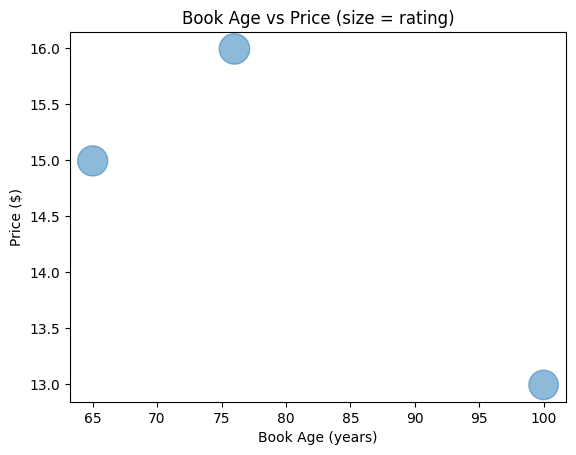

In [7]:
# Cell 6: Visualize results
genre_summary = final_df.groupby('genre').agg({
    'rating': 'mean',
    'price': 'mean',
    'page_count': 'mean'
}).round(2)
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
final_df.plot(kind='scatter', x='book_age', y='price', s=final_df['rating']*100, alpha=0.5)
plt.title('Book Age vs Price (size = rating)')
plt.xlabel('Book Age (years)')
plt.ylabel('Price ($)')
plt.savefig("scatter_plot.png")
plt.show()


In [8]:
from reprolab.environment import freeze_venv_dependencies
freeze_venv_dependencies('.my_venv')


Trying pip at: /Users/spoton/Documents/master_thesis/poc/reprolab/.my_venv/bin/pip
Running command: /Users/spoton/Documents/master_thesis/poc/reprolab/.my_venv/bin/pip freeze
Pip dependencies saved to requirements.txt
Found 65 packages
Not a Conda environment or not activated. Skipping Conda export.

To recreate the environment:
- For pip: Activate the virtual environment and run: `pip install -r requirements.txt`


In [ ]:
end_experiment()


2025-07-16 10:49:57 - INFO - Ending experiment process
2025-07-16 10:49:57 - INFO - Step 1: Saving all notebooks
2025-07-16 10:49:57 - INFO - Attempting to save all Jupyter notebooks...
2025-07-16 10:49:57 - INFO - ipylab save command executed successfully
2025-07-16 10:49:57 - INFO - nbformat processing completed for 4 notebooks


In [ ]:
from reprolab.experiment import list_and_sort_git_tags
list_and_sort_git_tags()
# Pick your git tag, to download the reproducability package

In [ ]:
from reprolab.experiment import download_reproducability_package
download_reproducability_package('v1.13.0')